# T81-558: Applications of Deep Neural Networks
**Module 10: Time Series in Keras**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 10 Material

* Part 10.1: Time Series Data Encoding for Deep Learning [[Video]]() [[Notebook]](t81_558_class_10_1_timeseries.ipynb)
* Part 10.2: Programming LSTM with Keras and TensorFlow [[Video]]() [[Notebook]](t81_558_class_10_2_lstm.ipynb)
* Part 10.3: Text Generation with Keras and TensorFlow [[Video]]() [[Notebook]](t81_558_class_10_3_text_generation.ipynb)
* **Part 10.4: Image Captioning with Keras and TensorFlow** [[Video]]() [[Notebook]](t81_558_class_10_4_captioning.ipynb)
* Part 10.5: Temporal CNN in Keras and TensorFlow [[Video]]() [[Notebook]](t81_558_class_10_5_temporal_cnn.ipynb)

# Part 10.4: Image Captioning with Keras and TensorFlow

Image captioning is a new technology that combines LSTM text generation with the computer vision powers of a convolutional neural network.  I first saw this technology in [Andrej Karpathy's Dissertation](https://cs.stanford.edu/people/karpathy/main.pdf). Images from his work are shown here:

![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/karpathy_thesis.jpg "Captioning")

In this part, we will make use of LSTM and CNN to create a basic image captioning system. Transfer learning will be used to bring in these two projects:

* [InceptionV3](https://arxiv.org/abs/1512.00567)
* [Glove](https://nlp.stanford.edu/projects/glove/)

Inception is used to extract features from the images.  Glove is a set of Natural Language Processing (NLP) vectors for common words.

In [1]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from keras.applications.inception_v3 import InceptionV3
import keras.applications.inception_v3


from tqdm import tqdm
import keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import Input, layers
from keras import optimizers

from keras.models import Model

from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

Using TensorFlow backend.


In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
root_captioning = "/content/drive/My Drive/projects/captions"

In [ ]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text','Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]


In [6]:
print(len(lookup))
print(len(lex))
print(max_length)


8092
8763
32


In [ ]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [8]:
len(img)

8091

In [ ]:
train_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

In [10]:
print(len(train_images))
print(len(test_images))
print(len(lookup))

6000
1000
8092


In [ ]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [12]:
len(train_descriptions)

6000

In [13]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = keras.applications.mobilenet.preprocess_input

W0703 19:57:29.062439 140095027591040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 19:57:29.075807 140095027591040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 19:57:29.079685 140095027591040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 19:57:29.099365 140095027591040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0703 19:57:29.100255 1400950275

In [14]:
encode_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
def encodeImage(img):
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  x = keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = encode_model.predict(x) # Get the encoding vector for the image
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [ ]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [ ]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

In [18]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [19]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [20]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [21]:
max_length +=2
print(max_length)

34


In [ ]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
    x1, x2, y = [], [], []
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[np.array(x1), np.array(x2)], np.array(y)]
                x1, x2, y = [], [], []
                n=0

In [23]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

400000it [00:23, 16705.36it/s]

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [25]:
embedding_matrix.shape

(1652, 200)

In [26]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

W0703 19:58:06.438608 140095027591040 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0703 19:58:06.801928 140095027591040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
embedding_dim

200

In [28]:
caption_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [29]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

W0703 19:58:08.005269 140095027591040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [31]:
for i in tqdm(range(EPOCHS)):
    generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
    caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/1
2000/2000 [==============================] - 153s 76ms/step - loss: 4.1269


 10%|█         | 1/10 [02:33<23:02, 153.64s/it]

Epoch 1/1
2000/2000 [==============================] - 151s 76ms/step - loss: 3.4355


 20%|██        | 2/10 [05:04<20:23, 152.90s/it]

Epoch 1/1
2000/2000 [==============================] - 150s 75ms/step - loss: 3.2159


 30%|███       | 3/10 [07:35<17:45, 152.15s/it]

Epoch 1/1
2000/2000 [==============================] - 151s 76ms/step - loss: 3.0827


 40%|████      | 4/10 [10:06<15:10, 151.81s/it]

Epoch 1/1
2000/2000 [==============================] - 151s 75ms/step - loss: 2.9873


 50%|█████     | 5/10 [12:37<12:37, 151.57s/it]

Epoch 1/1
2000/2000 [==============================] - 151s 75ms/step - loss: 2.9112


 60%|██████    | 6/10 [15:08<10:05, 151.38s/it]

Epoch 1/1
2000/2000 [==============================] - 152s 76ms/step - loss: 2.8536


 70%|███████   | 7/10 [17:39<07:34, 151.50s/it]

Epoch 1/1
2000/2000 [==============================] - 152s 76ms/step - loss: 2.8063


 80%|████████  | 8/10 [20:12<05:03, 151.67s/it]

Epoch 1/1
2000/2000 [==============================] - 156s 78ms/step - loss: 2.7647


 90%|█████████ | 9/10 [22:48<02:33, 153.08s/it]

Epoch 1/1
2000/2000 [==============================] - 154s 77ms/step - loss: 2.7308


100%|██████████| 10/10 [25:22<00:00, 153.44s/it]


In [32]:
for i in tqdm(range(EPOCHS)):
    generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
    caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/1
2000/2000 [==============================] - 153s 77ms/step - loss: 2.7017


 10%|█         | 1/10 [02:33<23:00, 153.37s/it]

Epoch 1/1
2000/2000 [==============================] - 153s 77ms/step - loss: 2.6739


 20%|██        | 2/10 [05:06<20:26, 153.29s/it]

Epoch 1/1
2000/2000 [==============================] - 152s 76ms/step - loss: 2.6504


 30%|███       | 3/10 [07:38<17:50, 152.96s/it]

Epoch 1/1
2000/2000 [==============================] - 153s 77ms/step - loss: 2.6308


 40%|████      | 4/10 [10:11<15:18, 153.03s/it]

Epoch 1/1
2000/2000 [==============================] - 155s 77ms/step - loss: 2.6132


 50%|█████     | 5/10 [12:46<12:47, 153.55s/it]

Epoch 1/1
2000/2000 [==============================] - 153s 76ms/step - loss: 2.5962


 60%|██████    | 6/10 [15:19<10:12, 153.24s/it]

Epoch 1/1
2000/2000 [==============================] - 152s 76ms/step - loss: 2.5794


 70%|███████   | 7/10 [17:51<07:38, 152.94s/it]

Epoch 1/1
2000/2000 [==============================] - 153s 77ms/step - loss: 2.5654


 80%|████████  | 8/10 [20:24<05:05, 153.00s/it]

Epoch 1/1
2000/2000 [==============================] - 155s 77ms/step - loss: 2.5565


 90%|█████████ | 9/10 [22:59<02:33, 153.55s/it]

Epoch 1/1
2000/2000 [==============================] - 155s 78ms/step - loss: 2.5436


100%|██████████| 10/10 [25:34<00:00, 154.03s/it]


In [33]:
caption_model.optimizer.lr = 0.0001
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

for i in range(EPOCHS):
    generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
    caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


Epoch 1/1
1000/1000 [==============================] - 82s 82ms/step - loss: 2.4965
Epoch 1/1
1000/1000 [==============================] - 82s 82ms/step - loss: 2.4801
Epoch 1/1
1000/1000 [==============================] - 81s 81ms/step - loss: 2.4667
Epoch 1/1
1000/1000 [==============================] - 82s 82ms/step - loss: 2.4513
Epoch 1/1
1000/1000 [==============================] - 81s 81ms/step - loss: 2.4485
Epoch 1/1
1000/1000 [==============================] - 81s 81ms/step - loss: 2.4367
Epoch 1/1
1000/1000 [==============================] - 81s 81ms/step - loss: 2.4259
Epoch 1/1
1000/1000 [==============================] - 81s 81ms/step - loss: 2.4161
Epoch 1/1
1000/1000 [==============================] - 80s 80ms/step - loss: 2.4096
Epoch 1/1
1000/1000 [==============================] - 81s 81ms/step - loss: 2.4043


In [ ]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

/content/drive/My Drive/projects/captions/Flicker8k_Dataset/3485425825_c2f3446e73.jpg


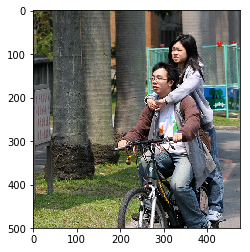

Caption: man in black hat and hat is sitting on bench
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/3490736665_38710f4b91.jpg


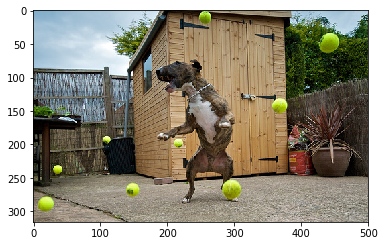

Caption: dog catches tennis ball
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/3256043809_47258e0b3e.jpg


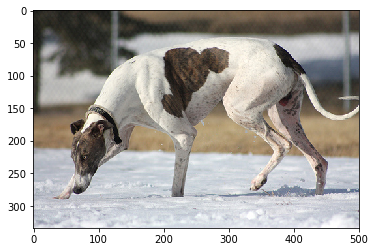

Caption: two dogs are running through the grass
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/2301525531_edde12d673.jpg


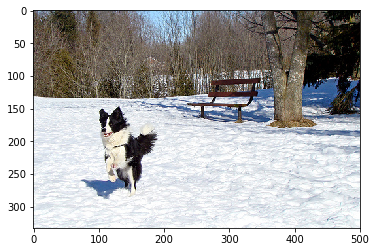

Caption: two black and white dogs play in the snow
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/3365783912_e12c3510d8.jpg


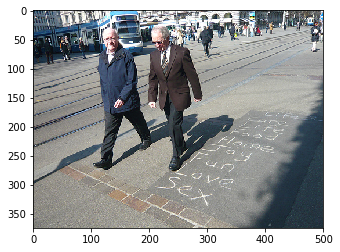

Caption: woman walking down sidewalk with big bag
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/2373234213_4ebe9c4ee5.jpg


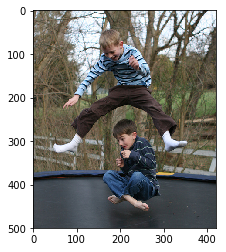

Caption: boy in red shirt is jumping on the trampoline
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/2663794355_e726ec7e05.jpg


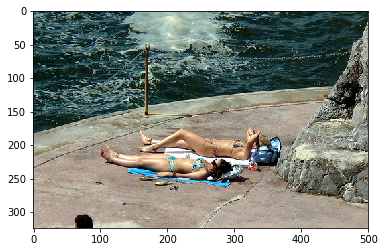

Caption: woman in swimming pool swinging her her her her her her her her her her her her her her her her her her her her her her her her her her her her
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/1659358141_0433c9bf99.jpg


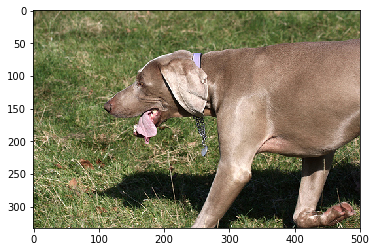

Caption: brown dog is running through the grass
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/3584561689_b6eb24dd70.jpg


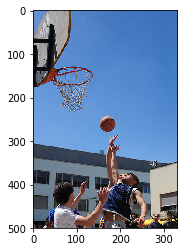

Caption: two men are playing on sports field
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/3458559770_12cf9f134e.jpg


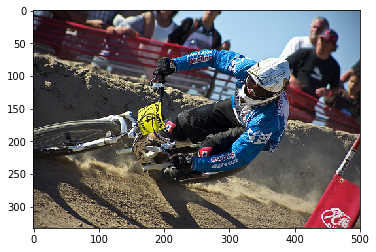

Caption: man in red helmet and helmet is riding bike on the beach
_____________________________________


In [35]:
for z in range(10):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [36]:
encoding_test[pic].shape

(2048,)

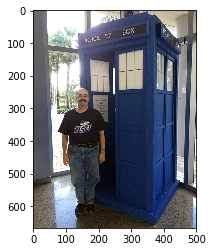

(1, 2048)
Caption: man in black shirt is sitting on bench reading book
_____________________________________


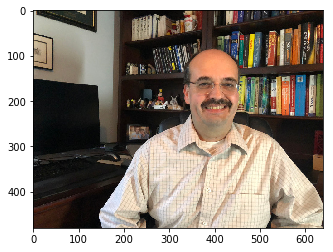

(1, 2048)
Caption: man in black shirt is sitting on wooden bench
_____________________________________


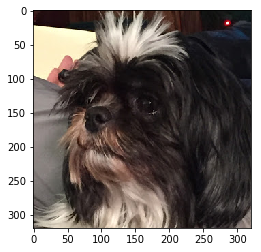

(1, 2048)
Caption: dog is running through the grass
_____________________________________


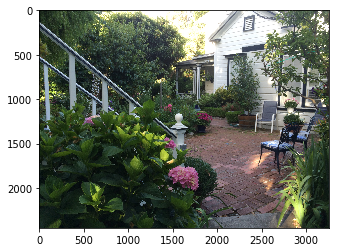

(1, 2048)
Caption: man sits on bench reading book
_____________________________________


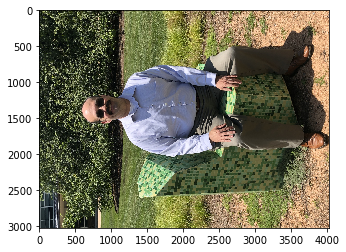

(1, 2048)
Caption: girl in pink shirt is jumping on rock
_____________________________________


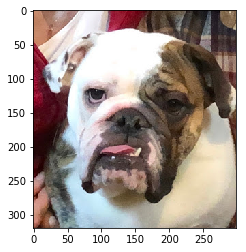

(1, 2048)
Caption: dog with red collar is standing on top of the grass
_____________________________________


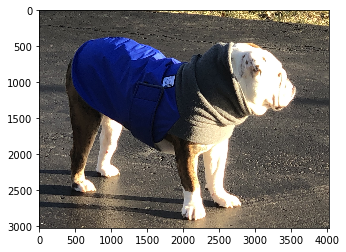

(1, 2048)
Caption: two dogs are playing tug of war with bottle
_____________________________________


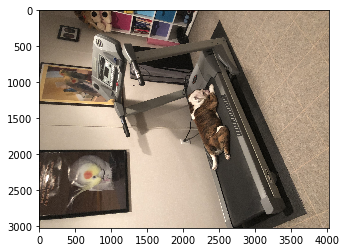

(1, 2048)
Caption: two dogs lay on bed
_____________________________________


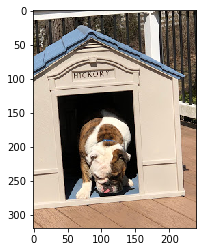

(1, 2048)
Caption: dog is jumping over bed
_____________________________________


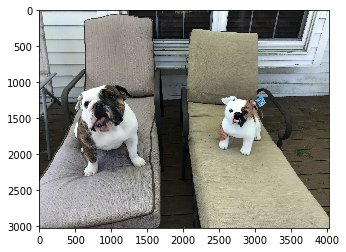

(1, 2048)
Caption: two dogs play with each other on the carpet
_____________________________________


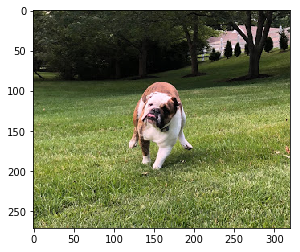

(1, 2048)
Caption: dog is running through the grass
_____________________________________


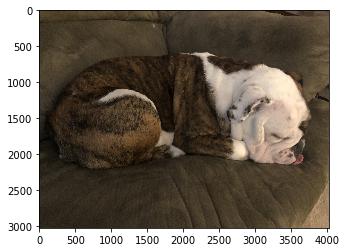

(1, 2048)
Caption: dog is biting its nose
_____________________________________


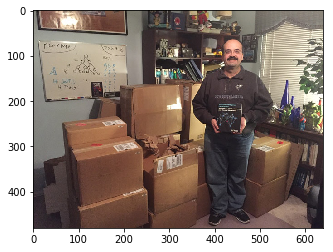

(1, 2048)
Caption: man in black shirt is standing by tables
_____________________________________


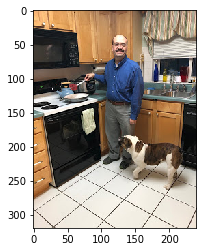

(1, 2048)
Caption: two dogs are playing tug of war with cloth
_____________________________________


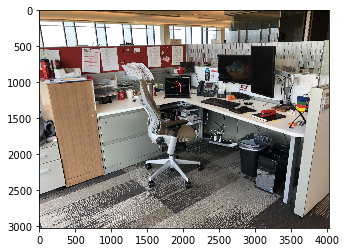

(1, 2048)
Caption: man in black shirt is sitting on wooden bench
_____________________________________


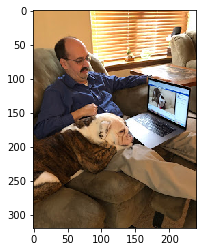

(1, 2048)
Caption: man and woman sit on the ground
_____________________________________


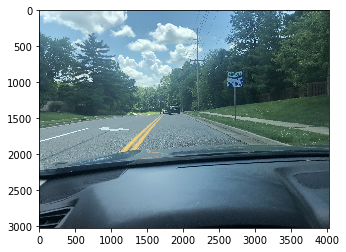

(1, 2048)
Caption: man in black shirt is sitting on bench next to woman in black coat
_____________________________________


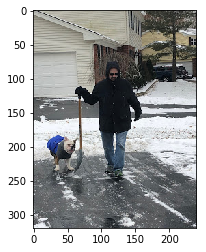

(1, 2048)
Caption: man in black shirt is walking down the street
_____________________________________


In [42]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

urls = [
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/2015-03-09-phd-2nd-cluster-visit-1.png?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/about-jeff-heaton-2018.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/annie_dog.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/bread_n_breakfast.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/family_christmas.png?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/github_rock.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/hickory.jpeg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/hickory_coat.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/hickory_exercise.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/hickory_home.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/hickory_n_stuffed.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/hickory_run.jpeg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/hickory_sleep.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/jeff_books.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/jeff_cook.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/jeff_cube.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/jeff_laptop.jpg?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/jeff_laptops.png?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/road.JPG?raw=true",
  "https://github.com/jeffheaton/t81_558_deep_learning/blob/master/photos/snow_shovel.jpg?raw=true"
]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")

# Module 10 Assignment

You can find the first assignment here: [assignment 10](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class10.ipynb)